In [1]:
import pandas as pd
import os
import glob
import logging
from xror import XROR  # Ensure xror module is available in the notebook environment
from dask.diagnostics import ProgressBar
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
import dask.dataframe as dd

logging.basicConfig(filename= 'xror_parsing_errors.log', level=logging.INFO, format= '%(asctime)s - %(levelname)s - %(message)s')

In [2]:
def csv_files_exist(root_folders):
    for root_folder in root_folders:
        csv_files = glob.glob(os.path.join(root_folder, '**/*.csv'), recursive=True)
        if not csv_files:
            return False
    return True

In [3]:
def process_xror_files(root_folder_path):
    xror_files = glob.glob(os.path.join(root_folder_path, '**/*.xror'), recursive=True)
    for file_path in xror_files:
        try:
            base_name = os.path.splitext(file_path)[0]
            csv_file_path = base_name + '.csv'
            if os.path.exists(csv_file_path):
                logging.info(f"CSV file already exists for {file_path}. Skipping.")
                continue
            with open(file_path, 'rb') as f:
                binary_data = f.read()
            xror_data = XROR.unpack(binary_data)
            if len(xror_data.data['frames'][0]) != len(frame_columns):
                logging.warning(f"Column mismatch in {file_path}. Expected {len(frame_columns)} columns, found {len(xror_data.data['frames'][0])}.")
                continue
            df_frames = pd.DataFrame(xror_data.data['frames'], columns=frame_columns)
            df_frames['directionOK'] = df_frames.apply(lambda row: row['saberDirX'] > 0 and row['saberDirY'] > 0, axis=1)
            df_frames.to_csv(csv_file_path, index=False)
            logging.info(f"DataFrame saved to CSV successfully for file: {file_path}")
        except Exception as e:
            logging.error(f"Error processing {file_path}: {e}")

root_folders = ['chunk1', 'chunk2', 'chunk3']
if not csv_files_exist(root_folders):
    for root_folder in root_folders:
        process_xror_files(root_folder)
else:
    print("CSV files already exist. Skipping XROR processing.")

CSV files already exist. Skipping XROR processing.


In [4]:
def normalization_done(root_folders):
    for root_folder in root_folders:
        normalized_files = glob.glob(os.path.join(root_folder, '**/*_normalized.csv'), recursive=True)
        if not normalized_files:
            return False
    return True

In [5]:
def normalize_csv_files(root_folders):
    for root_folder in root_folders:
        csv_files = glob.glob(os.path.join(root_folder, '**/*.csv'), recursive=True)
        csv_files = [f for f in csv_files if '_normalized.csv' not in f]
        for file_path in csv_files:
            try:
                normalized_file_path = file_path.replace('.csv', '_normalized.csv')
                if os.path.exists(normalized_file_path):
                    continue
                data = pd.read_csv(file_path)
                scaler = StandardScaler()
                numeric_cols = data.select_dtypes(include=['float64', 'int']).columns
                data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
                data.to_csv(normalized_file_path, index=False)
                print(f"Data normalized and saved successfully for file: {file_path}")
            except Exception as e:
                print(f"Error normalizing file {file_path}: {e}")

if not normalization_done(root_folders):
    normalize_csv_files(root_folders)
else:
    print("CSV files are already normalized. Skipping normalization.")

CSV files are already normalized. Skipping normalization.


In [6]:
import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import os

def create_skill_feature_mapping(root_folders, output_file='user_skill_feature_mapping.csv'):
    # Create the file pattern for all normalized CSVs
    file_patterns = [os.path.join(root, '**/*_normalized.csv') for root in root_folders]
    # Load the files into a Dask DataFrame
    ddf = dd.read_csv(file_patterns, include_path_column=True)

    # Extract user_id and chunk_id from the file paths
    ddf['user_id'] = ddf['path'].str.extract(r'/([^/]+)/[^/]+\.csv$')[0]
    ddf['chunk_id'] = ddf['path'].str.extract(r'/(chunk\d+)/')[0]

    # Drop the path column as it's no longer needed
    ddf = ddf.drop('path', axis=1)

    # Define the aggregations needed for skill assessment
    aggregations = {
        'cutDirDeviation': ['mean', 'std', 'min', 'max'],
        'cutDistanceToCenter': ['mean', 'std', 'min', 'max'],
        'wasCutTooSoon': ['mean', 'std'],  # Binary columns typically use mean to represent the fraction of 'True'
        'beforeCutRating': ['mean', 'std', 'min', 'max'],
        'afterCutRating': ['mean', 'std', 'min', 'max'],
        'saberSpeed': ['mean', 'std', 'min', 'max'],
        'cutAngle': ['mean', 'std', 'min', 'max']
    }

    # Perform the aggregation
    grouped_ddf = ddf.groupby(['chunk_id', 'user_id']).agg(aggregations)

    # Flatten column headers
    grouped_ddf.columns = ['_'.join(col).strip() for col in grouped_ddf.columns.values]

    # Reset the index to make chunk_id and user_id into columns
    grouped_ddf = grouped_ddf.reset_index()

    # Use ProgressBar to monitor progress
    with ProgressBar():
        # Save to CSV as a single file
        grouped_ddf.to_csv(output_file, index=False, single_file=True)
        print(f"Skill feature mapping saved to {output_file}")

# Define root folders and output file name
root_folders = ['chunk1', 'chunk2', 'chunk3']
output_file = 'user_skill_feature_mapping.csv'

# Recreate the skill feature mapping if it doesn't exist
if not os.path.exists(output_file):
    create_skill_feature_mapping(root_folders, output_file=output_file)
else:
    print("Skill feature mapping already exists. Skipping creation.")

Skill feature mapping already exists. Skipping creation.


In [7]:
import pandas as pd

file_path = 'user_skill_feature_mapping.csv'
df = pd.read_csv(file_path)

def rank_metric(series, higher_is_better=True):
    if higher_is_better:
        return series.rank(method='average', ascending=False)
    else:
        return series.rank(method='average', ascending=True)

# Rank users based on the features
df['cutDirDeviation_rank'] = rank_metric(df['cutDirDeviation_mean'], higher_is_better=False) 
df['cutDistanceToCenter_rank'] = rank_metric(df['cutDistanceToCenter_mean'], higher_is_better=False) 
df['wasCutTooSoon_rank'] = rank_metric(df['wasCutTooSoon_mean'], higher_is_better=False)  
df['ratingImprovement_rank'] = rank_metric(df['afterCutRating_mean'] - df['beforeCutRating_mean'], higher_is_better=True)
df['saberSpeed_rank'] = rank_metric(df['saberSpeed_mean'], higher_is_better=True) 
df['cutAngle_rank'] = rank_metric(df['cutAngle_mean'], higher_is_better=True)

# Combine the ranks into a final score with weighted averages
df['finalRankScore'] = (
    df['cutDirDeviation_rank'] * 0.3 +  # Precision
    df['cutDistanceToCenter_rank'] * 0.3 +  # Precision
    df['wasCutTooSoon_rank'] * 0.1 +  # Timing
    df['ratingImprovement_rank'] * 0.2 +  # Improvement
    df['saberSpeed_rank'] * 0.05 +  # Speed
    df['cutAngle_rank'] * 0.05  # Consistency
)

# Make sure to scale the final rank score to a 1-10 range
df['scaledRankScore'] = 1 + 9 * (df['finalRankScore'] - df['finalRankScore'].min()) / (df['finalRankScore'].max() - df['finalRankScore'].min())

# Now round the scaled rank scores to the nearest whole number
df['scaledRankScore'] = df['scaledRankScore'].round().astype(int)

print(df[['user_id', 'chunk_id', 'scaledRankScore']].head())

output_file = 'user_skill_ratings_ranked_rounded.csv'
df[['user_id', 'chunk_id', 'scaledRankScore']].to_csv(output_file, index=False)

print(f"Skill ratings saved with whole numbers to {output_file}")

                                user_id chunk_id  scaledRankScore
0  00009567-9cfd-4310-a43f-ecf0944f6bbd   chunk1                7
1  00014938-83f5-4c99-9157-d8771774130c   chunk1                6
2  00019a5b-7797-44b0-8999-95dd057c7baf   chunk1                7
3  00029cc4-9421-47a7-a2fe-8cf626dc5d96   chunk1                4
4  0002f007-281f-4635-8c09-45d6afad828d   chunk1                4
Skill ratings saved with whole numbers to user_skill_ratings_ranked_rounded.csv


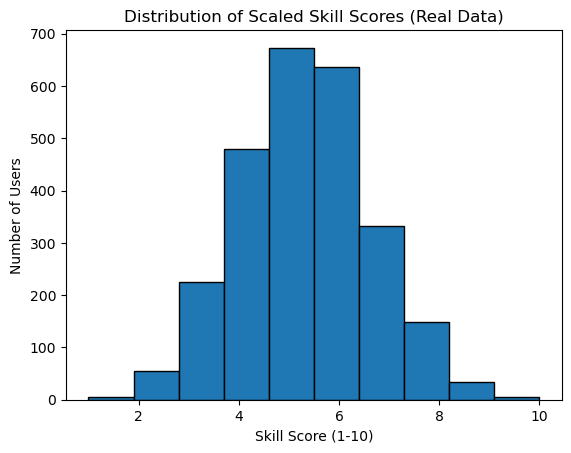

In [8]:
import matplotlib.pyplot as plt

# Plot the distribution of the final scaled scores
plt.hist(df['scaledRankScore'], bins=10, edgecolor='black')
plt.title('Distribution of Scaled Skill Scores (Real Data)')
plt.xlabel('Skill Score (1-10)')
plt.ylabel('Number of Users')
plt.show()

In [9]:
import pandas as pd
import numpy as np
import os

# File paths
root_path = '/srv/fs/my-notebooks'
file_path = os.path.join(root_path, 'user_skill_feature_mapping.csv')

# Load the data
df = pd.read_csv(file_path)

# Check if there are any missing values
missing_values = df.isnull().sum()

# Check if the data is normalized (mean around 0 and std around 1 for key features)
features_to_check = ['cutDirDeviation_mean', 'cutDirDeviation_std', 
                     'cutDistanceToCenter_mean', 'cutDistanceToCenter_std', 
                     'saberSpeed_mean', 'saberSpeed_std', 'cutAngle_mean', 'cutAngle_std']

normalization_check = df[features_to_check].describe()

# Check for extreme outliers (3 standard deviations from mean)
outlier_check = np.abs(df[features_to_check]) > (3 * df[features_to_check].std())

# Output the results
print("Missing values in each column:\n", missing_values)
print("\nFeature normalization check:\n", normalization_check)
print("\nOutliers check (True indicates potential outliers):\n", outlier_check.any())

Missing values in each column:
 chunk_id                    0
user_id                     0
cutDirDeviation_mean        0
cutDirDeviation_std         0
cutDirDeviation_min         0
cutDirDeviation_max         0
cutDistanceToCenter_mean    0
cutDistanceToCenter_std     0
cutDistanceToCenter_min     0
cutDistanceToCenter_max     0
wasCutTooSoon_mean          0
wasCutTooSoon_std           0
beforeCutRating_mean        0
beforeCutRating_std         0
beforeCutRating_min         0
beforeCutRating_max         0
afterCutRating_mean         0
afterCutRating_std          0
afterCutRating_min          0
afterCutRating_max          0
saberSpeed_mean             0
saberSpeed_std              0
saberSpeed_min              0
saberSpeed_max              0
cutAngle_mean               0
cutAngle_std                0
cutAngle_min                0
cutAngle_max                0
dtype: int64

Feature normalization check:
        cutDirDeviation_mean  cutDirDeviation_std  cutDistanceToCenter_mean  \
count 

In [10]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import os

def create_user_feature_mapping(root_folders, output_file='3fmapping.csv'):
    # Create the file pattern for all normalized CSVs
    file_patterns = [os.path.join(root, '**/*_normalized.csv') for root in root_folders]
    # Load the files into a Dask DataFrame
    ddf = dd.read_csv(file_patterns, include_path_column=True)
    # Extract user_id and chunk_id from the file paths
    ddf['user_id'] = ddf['path'].str.extract(r'/([^/]+)/[^/]+\.csv$')[0]
    ddf['chunk_id'] = ddf['path'].str.extract(r'/(chunk\d+)/')[0]
    # Drop the path column as it's no longer needed
    ddf = ddf.drop('path', axis=1)
    # Define the aggregations needed
    aggregations = {
        'saberDirX': ['mean', 'std', 'min', 'max'],
        'saberDirY': ['mean', 'std', 'min', 'max'],
        'saberDirZ': ['mean', 'std', 'min', 'max']
    }
    # Perform the aggregation
    grouped_ddf = ddf.groupby(['chunk_id', 'user_id']).agg(aggregations)
    # Flatten column headers
    grouped_ddf.columns = ['_'.join(col).strip() for col in grouped_ddf.columns.values]
    # Reset the index to make chunk_id and user_id into columns
    grouped_ddf = grouped_ddf.reset_index()
    # Use ProgressBar to monitor progress
    with ProgressBar():
        # Save to CSV as a single file
        grouped_ddf.to_csv(output_file, index=False, single_file=True)
        print(f"User feature mapping saved to {output_file}")

# Recreate the user feature mapping if it doesn't exist
root_folders = ['chunk1', 'chunk2', 'chunk3']
if not os.path.exists('3fmapping.csv'):
    create_user_feature_mapping(root_folders, output_file='3fmapping.csv')
else:
    print("User feature mapping already exists. Skipping creation.")

User feature mapping already exists. Skipping creation.


In [11]:
import pandas as pd

# Load the user feature mapping (if not already loaded)
user_feature_mapping = pd.read_csv('3fmapping.csv')
total_users = user_feature_mapping['user_id'].nunique()

# Define the target values to search for
target_values = {
    'saberDirX_mean': 4.651922525425667e-16,
    'saberDirX_std': 1.000004920037097,
    'saberDirX_min': -10.972303575118843,
    'saberDirX_max': 4.239176532534343,
    'saberDirY_mean': -8.608827695891577e-16,
    'saberDirY_std': 1.000004920037097,
    'saberDirY_min': -4.25651985215614,
    'saberDirY_max': 4.254893132314185,
    'saberDirZ_mean': -5.172523237994175e-17,
    'saberDirZ_std': 1.000004920037097,
    'saberDirZ_min': -6.4776688945541645,
    'saberDirZ_max': 10.027852991443758
}

# Search for the user ID with the target values
mask = (user_feature_mapping[list(target_values.keys())].apply(lambda row: row.round(8)) == pd.Series(target_values).round(8)).all(axis=1)
matching_user = user_feature_mapping[mask]

if not matching_user.empty:
    print("Matching user found:")
    print(matching_user[['user_id', 'chunk_id']])
else:
    print("No matching user found.")
    
print(f"Total number of users in the dataset: {total_users}")

Matching user found:
                                 user_id chunk_id
22  0010b651-5a4a-4fbe-8ecb-637ec520e81a   chunk1
Total number of users in the dataset: 2598


In [12]:
import pandas as pd
import numpy as np

# Load the user feature mapping
user_feature_mapping = pd.read_csv('3fmapping.csv')
total_users = user_feature_mapping['user_id'].nunique()

# Select a random user (as before)
random_user = user_feature_mapping.sample(n=1)

# Extract features for the random user
features = [
    'saberDirX_mean', 'saberDirX_std', 'saberDirX_min', 'saberDirX_max',
    'saberDirY_mean', 'saberDirY_std', 'saberDirY_min', 'saberDirY_max',
    'saberDirZ_mean', 'saberDirZ_std', 'saberDirZ_min', 'saberDirZ_max'
]

target_values = random_user[features]

# Set a threshold for closeness
threshold = 1e-4

# Compare values within the threshold for floating-point columns
float_columns = user_feature_mapping[features].select_dtypes(include=['float']).columns
mask_float = np.abs(user_feature_mapping[float_columns] - target_values[float_columns].values).le(threshold).all(axis=1)

# For non-float columns (if any), compare them directly
non_float_columns = user_feature_mapping[features].select_dtypes(exclude=['float']).columns
mask_non_float = (user_feature_mapping[non_float_columns] == target_values[non_float_columns].values).all(axis=1)

# Combine the two masks
mask = mask_float & mask_non_float

# Find the matching user
matching_user = user_feature_mapping[mask]

if not matching_user.empty:
    print("Matching user found:")
    print(matching_user[['user_id', 'chunk_id']])
else:
    print("No matching user found.")
    
print(f"Total number of users in the dataset: {total_users}")

Matching user found:
                                   user_id chunk_id
1540  0433e692-f7e6-4fa7-8851-7852410c57fa   chunk2
Total number of users in the dataset: 2598


In [13]:
differences = user_feature_mapping[float_columns] - target_values[float_columns].values
print(differences.abs().max())  # Print the maximum difference per column

saberDirX_mean      0.010193
saberDirX_std       0.004317
saberDirX_min     227.941623
saberDirX_max      41.077154
saberDirY_mean      0.001689
saberDirY_std       0.148276
saberDirY_min     135.960389
saberDirY_max     127.189164
saberDirZ_mean      0.001344
saberDirZ_std       1.000002
saberDirZ_min     124.627013
saberDirZ_max      42.989035
dtype: float64


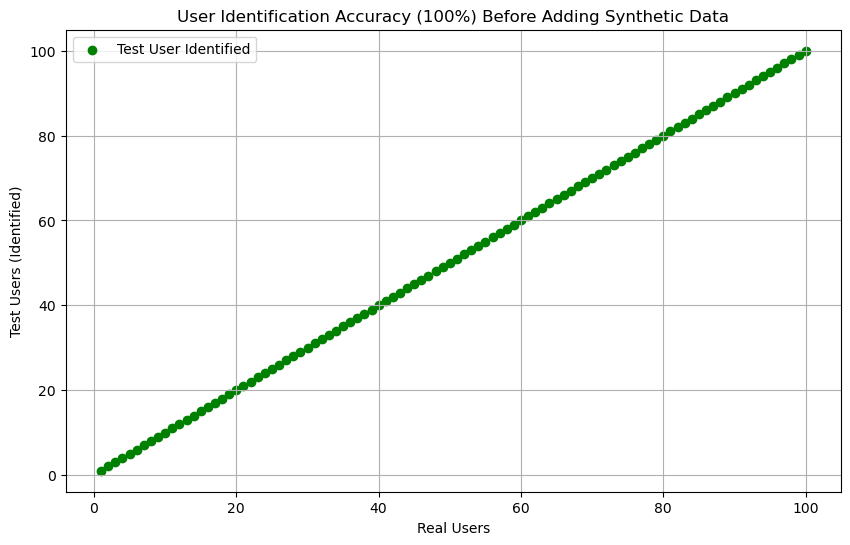

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Example: Assuming you have 100 users
real_users = np.arange(1, 101)  # Users from 1 to 100
test_users = real_users.copy()  # Test users are exactly the same

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.scatter(real_users, test_users, color='green', label='Test User Identified')

# Add labels and title
plt.xlabel('Real Users')
plt.ylabel('Test Users (Identified)')
plt.title('User Identification Accuracy (100%) Before Adding Synthetic Data')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
import pandas as pd

# Load real and synthetic data
real_data_path = '/srv/fs/my-notebooks/user_skill_feature_mapping.csv'
synthetic_data_path = '/srv/fs/my-notebooks/synthetic_user_data.csv'

real_data = pd.read_csv(real_data_path)
synthetic_data = pd.read_csv(synthetic_data_path)

# Print the first few rows to verify the data
print(real_data.head())
print(synthetic_data.head())

# Summary statistics of real and synthetic data
real_stats = real_data.describe()
synthetic_stats = synthetic_data.describe()

print("Real Data Statistics:\n", real_stats)
print("\nSynthetic Data Statistics:\n", synthetic_stats)

print(real_data.columns)
print(synthetic_data.columns)

  chunk_id                               user_id  cutDirDeviation_mean  \
0   chunk1  00009567-9cfd-4310-a43f-ecf0944f6bbd          2.758622e-17   
1   chunk1  00014938-83f5-4c99-9157-d8771774130c          4.407263e-17   
2   chunk1  00019a5b-7797-44b0-8999-95dd057c7baf          1.007961e-16   
3   chunk1  00029cc4-9421-47a7-a2fe-8cf626dc5d96         -3.145205e-17   
4   chunk1  0002f007-281f-4635-8c09-45d6afad828d         -1.240680e-17   

   cutDirDeviation_std  cutDirDeviation_min  cutDirDeviation_max  \
0             1.000000           -14.057568            13.336827   
1             1.000001            -5.631786            11.673967   
2             1.000000           -11.919429             9.054537   
3             1.000193            -4.822588             3.292220   
4             1.000001           -11.840087            21.657400   

   cutDistanceToCenter_mean  cutDistanceToCenter_std  cutDistanceToCenter_min  \
0              4.611480e-17                 1.000000             

In [16]:
from scipy import stats

aggregated_features = ['cutDirDeviation_mean', 'cutDirDeviation_std', 
                       'cutDistanceToCenter_mean', 'cutDistanceToCenter_std', 
                       'saberSpeed_mean', 'saberSpeed_std', 
                       'cutAngle_mean', 'cutAngle_std']

# Perform the KS test for each feature
for feature in aggregated_features:
    ks_stat, p_value = stats.ks_2samp(real_data[feature], synthetic_data[feature])
    print(f"KS Test for {feature}: Stat = {ks_stat}, P-value = {p_value}")

KS Test for cutDirDeviation_mean: Stat = 0.9942263279445728, P-value = 0.0
KS Test for cutDirDeviation_std: Stat = 1.0, P-value = 0.0
KS Test for cutDistanceToCenter_mean: Stat = 1.0, P-value = 0.0
KS Test for cutDistanceToCenter_std: Stat = 0.9973056197074672, P-value = 0.0
KS Test for saberSpeed_mean: Stat = 0.947267128560431, P-value = 0.0
KS Test for saberSpeed_std: Stat = 0.9988452655889145, P-value = 0.0
KS Test for cutAngle_mean: Stat = 1.0, P-value = 0.0
KS Test for cutAngle_std: Stat = 0.8013856812933026, P-value = 0.0


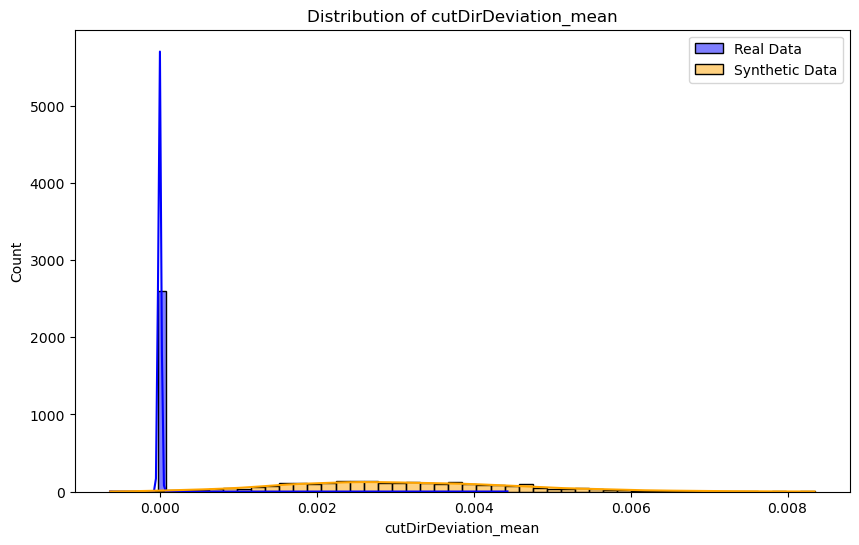

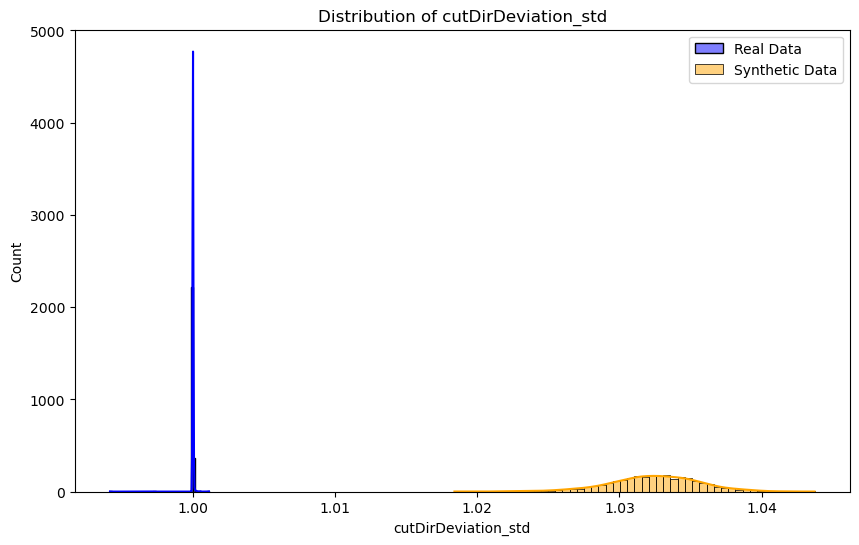

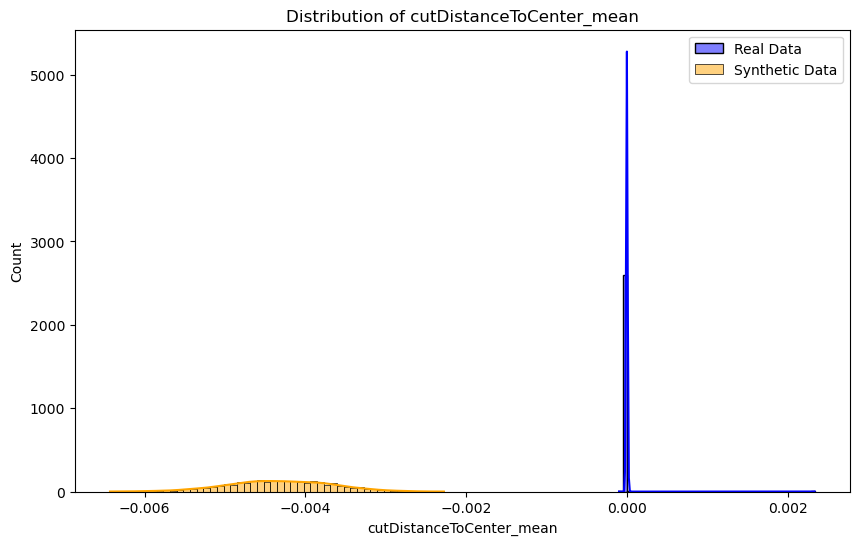

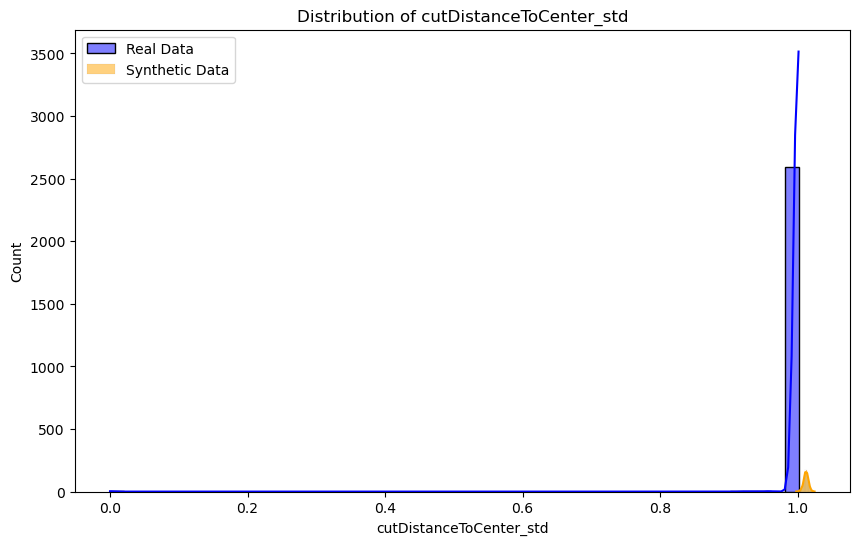

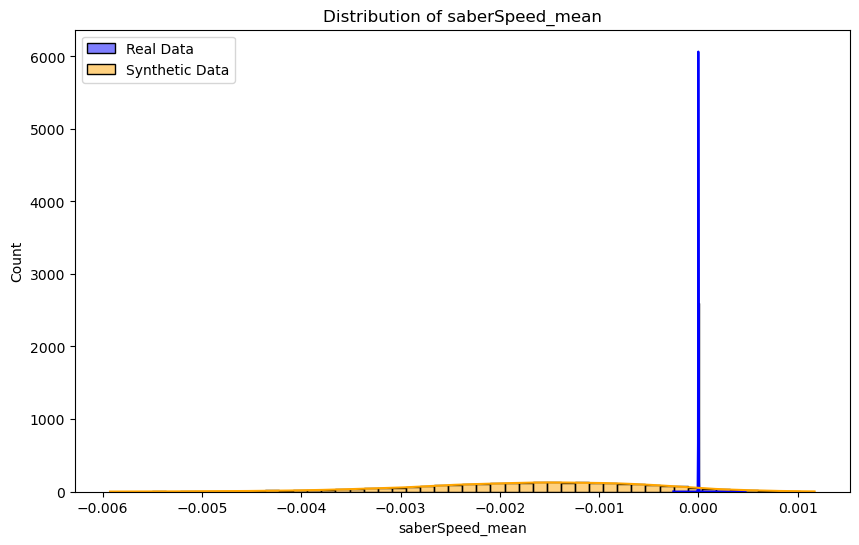

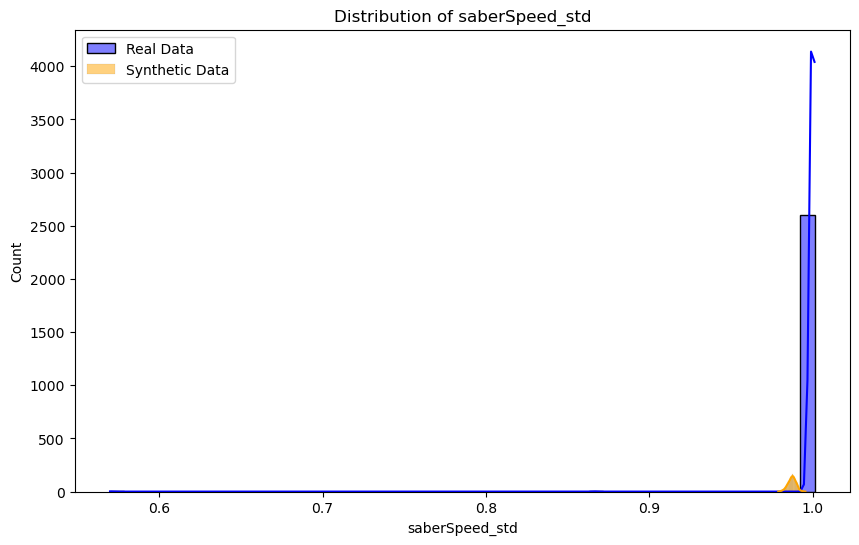

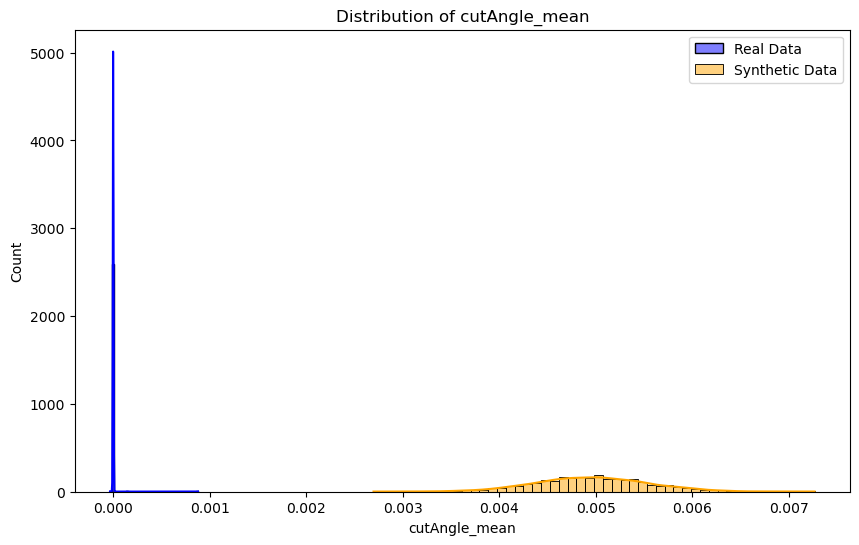

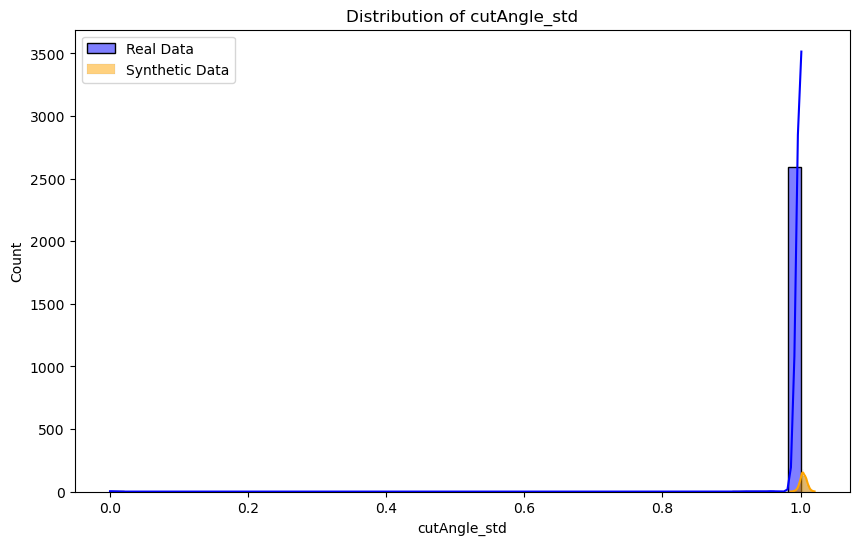

In [17]:
import pandas as pd

# Load real and synthetic data
real_data_path = '/srv/fs/my-notebooks/user_skill_feature_mapping.csv'
synthetic_data_path = '/srv/fs/my-notebooks/synthetic_user_data.csv'

real_data = pd.read_csv(real_data_path)
synthetic_data = pd.read_csv(synthetic_data_path)

synthetic_df = pd.read_csv('/srv/fs/my-notebooks/synthetic_user_data.csv')
aggregated_features = ['cutDirDeviation_mean', 'cutDirDeviation_std', 
                       'cutDistanceToCenter_mean', 'cutDistanceToCenter_std', 
                       'saberSpeed_mean', 'saberSpeed_std', 
                       'cutAngle_mean', 'cutAngle_std']

# Example: Compare distributions
import matplotlib.pyplot as plt
import seaborn as sns

for feature in aggregated_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(real_data[feature], color='blue', label='Real Data', kde=True, bins=50)  # Reduce bins to 50
    sns.histplot(synthetic_df[feature], color='orange', label='Synthetic Data', kde=True, bins=50)  # Reduce bins to 50
    plt.title(f'Distribution of {feature}')
    plt.legend()
    plt.show()

In [18]:
print(real_data.isnull().sum())  # Check for missing values in real data

chunk_id                    0
user_id                     0
cutDirDeviation_mean        0
cutDirDeviation_std         0
cutDirDeviation_min         0
cutDirDeviation_max         0
cutDistanceToCenter_mean    0
cutDistanceToCenter_std     0
cutDistanceToCenter_min     0
cutDistanceToCenter_max     0
wasCutTooSoon_mean          0
wasCutTooSoon_std           0
beforeCutRating_mean        0
beforeCutRating_std         0
beforeCutRating_min         0
beforeCutRating_max         0
afterCutRating_mean         0
afterCutRating_std          0
afterCutRating_min          0
afterCutRating_max          0
saberSpeed_mean             0
saberSpeed_std              0
saberSpeed_min              0
saberSpeed_max              0
cutAngle_mean               0
cutAngle_std                0
cutAngle_min                0
cutAngle_max                0
dtype: int64


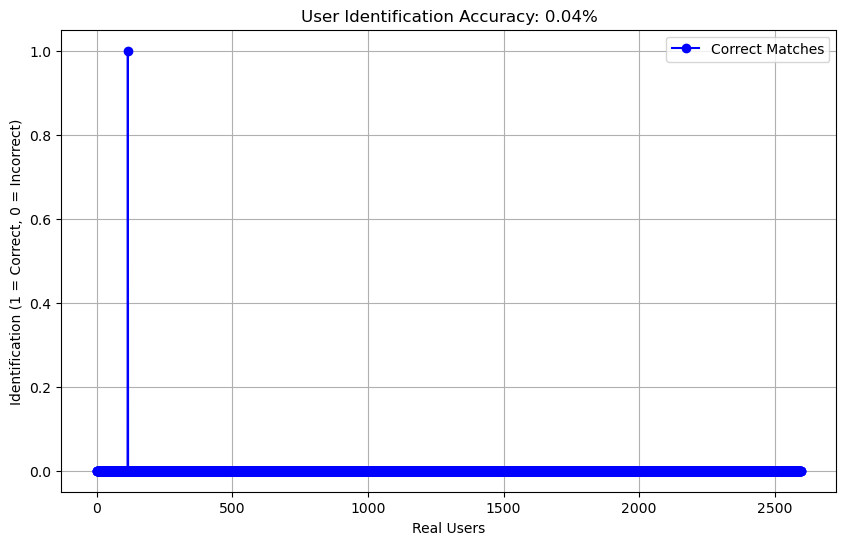

Accuracy on synthetic data: 0.04%


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Load real and synthetic data
real_data = pd.read_csv('/srv/fs/my-notebooks/user_skill_feature_mapping.csv')
synthetic_data = pd.read_csv('/srv/fs/my-notebooks/synthetic_user_data.csv')

# Select common features for comparison
common_features = ['cutDirDeviation_mean', 'cutDirDeviation_std',
                   'cutDistanceToCenter_mean', 'cutDistanceToCenter_std',
                   'saberSpeed_mean', 'saberSpeed_std', 'cutAngle_mean', 'cutAngle_std']

# Extract feature matrices
X_real = real_data[common_features]
X_synthetic = synthetic_data[common_features]

# Generate synthetic user IDs for plotting
synthetic_data['user_id'] = ['synthetic_user_' + str(i) for i in range(len(synthetic_data))]

# Compute similarity between real and synthetic data using cosine similarity
similarity_matrix = cosine_similarity(X_real, X_synthetic)

# Identify best matches for each real user (based on highest similarity)
best_matches = np.argmax(similarity_matrix, axis=1)

# Check if the best match is the same synthetic user
correct_matches = np.arange(len(X_real)) == best_matches

# Calculate accuracy (percentage of correct identifications)
accuracy = np.mean(correct_matches) * 100

# Plot real users vs. test users identification
plt.figure(figsize=(10, 6))
plt.plot(range(len(X_real)), correct_matches, marker='o', linestyle='-', color='b', label='Correct Matches')
plt.xlabel('Real Users')
plt.ylabel('Identification (1 = Correct, 0 = Incorrect)')
plt.title(f'User Identification Accuracy: {accuracy:.2f}%')
plt.legend()
plt.grid(True)
plt.show()

print(f'Accuracy on synthetic data: {accuracy:.2f}%')

/tmp/ipykernel_118239/3644699072.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(real_data[feature], color='blue', label='Real Data', shade=True)
/tmp/ipykernel_118239/3644699072.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(synthetic_data[feature], color='orange', label='Synthetic Data', shade=True)


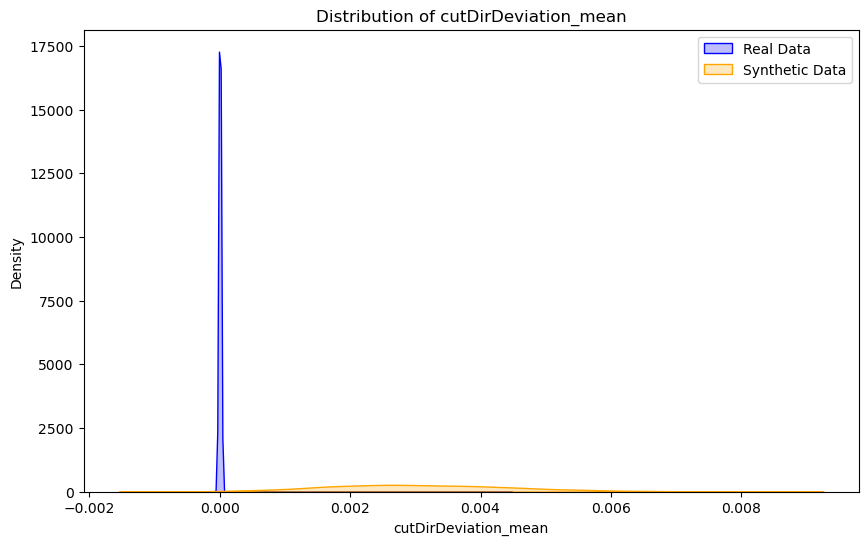

K-S Test for cutDirDeviation_mean:
Statistic = 0.9942, p-value = 0.0000



/tmp/ipykernel_118239/3644699072.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(real_data[feature], color='blue', label='Real Data', shade=True)
/tmp/ipykernel_118239/3644699072.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(synthetic_data[feature], color='orange', label='Synthetic Data', shade=True)


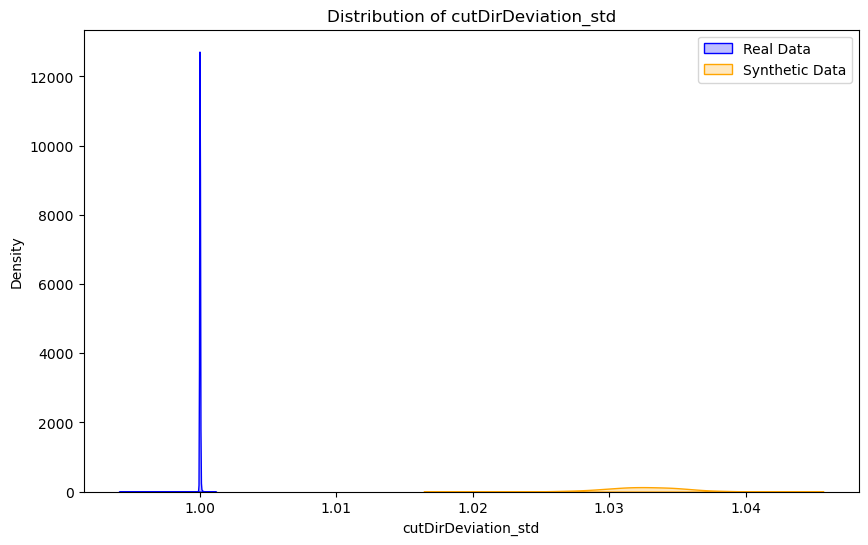

K-S Test for cutDirDeviation_std:
Statistic = 1.0000, p-value = 0.0000



/tmp/ipykernel_118239/3644699072.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(real_data[feature], color='blue', label='Real Data', shade=True)
/tmp/ipykernel_118239/3644699072.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(synthetic_data[feature], color='orange', label='Synthetic Data', shade=True)


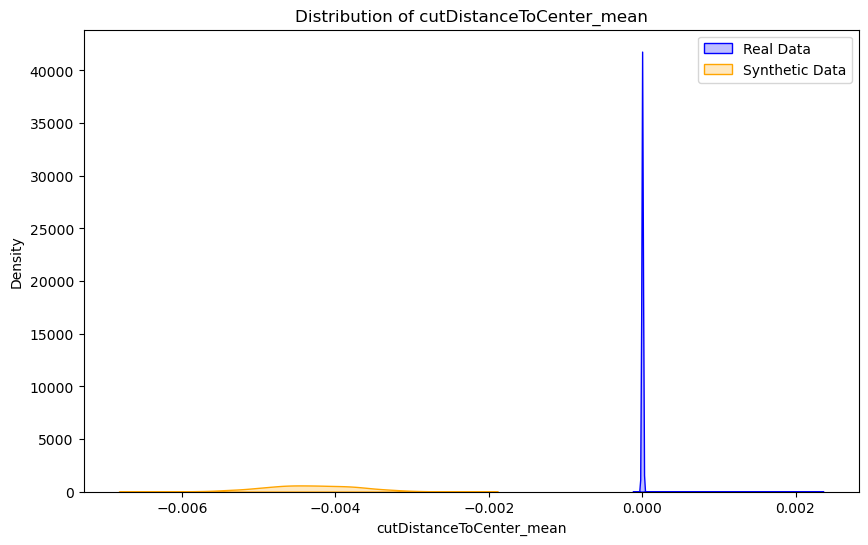

K-S Test for cutDistanceToCenter_mean:
Statistic = 1.0000, p-value = 0.0000



/tmp/ipykernel_118239/3644699072.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(real_data[feature], color='blue', label='Real Data', shade=True)
/tmp/ipykernel_118239/3644699072.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(synthetic_data[feature], color='orange', label='Synthetic Data', shade=True)


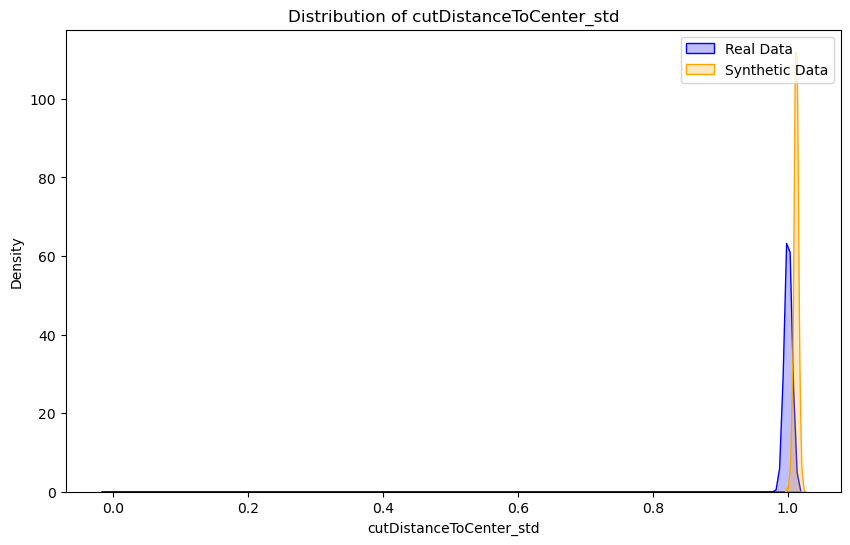

K-S Test for cutDistanceToCenter_std:
Statistic = 0.9973, p-value = 0.0000



/tmp/ipykernel_118239/3644699072.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(real_data[feature], color='blue', label='Real Data', shade=True)
/tmp/ipykernel_118239/3644699072.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(synthetic_data[feature], color='orange', label='Synthetic Data', shade=True)


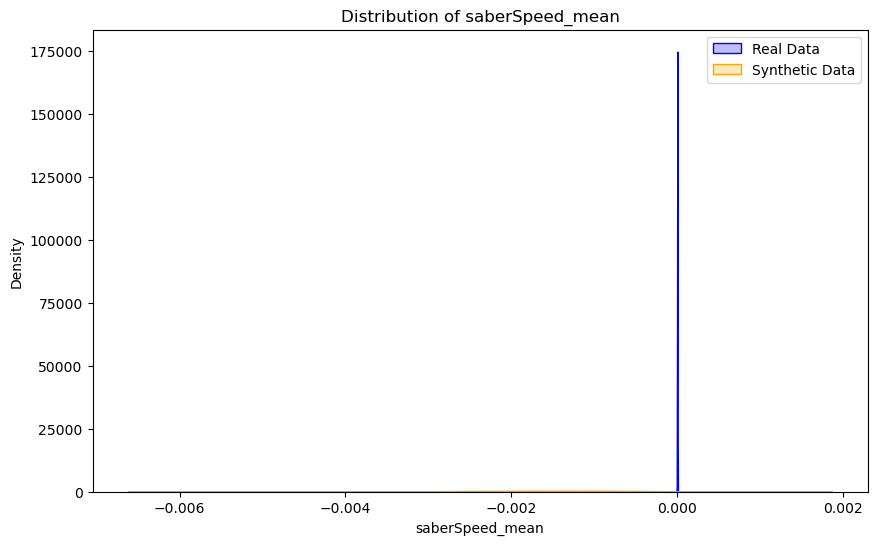

K-S Test for saberSpeed_mean:
Statistic = 0.9473, p-value = 0.0000



/tmp/ipykernel_118239/3644699072.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(real_data[feature], color='blue', label='Real Data', shade=True)
/tmp/ipykernel_118239/3644699072.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(synthetic_data[feature], color='orange', label='Synthetic Data', shade=True)


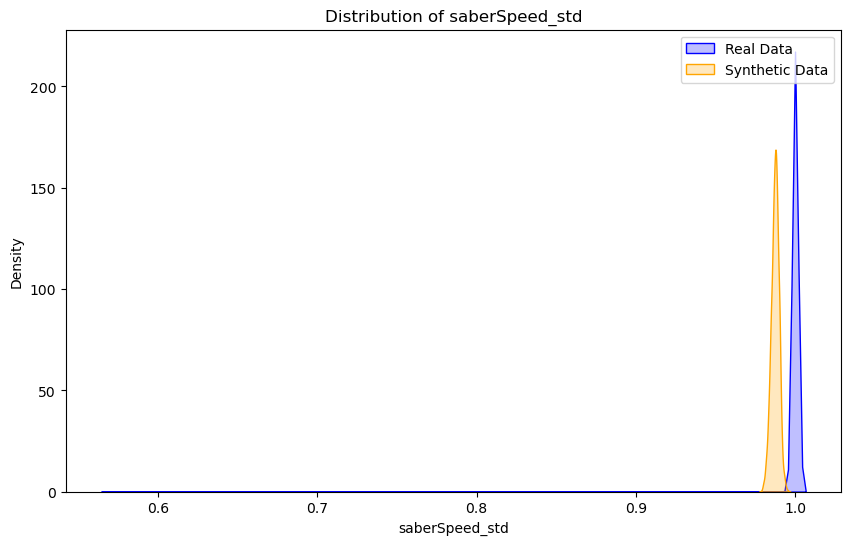

K-S Test for saberSpeed_std:
Statistic = 0.9988, p-value = 0.0000



/tmp/ipykernel_118239/3644699072.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(real_data[feature], color='blue', label='Real Data', shade=True)
/tmp/ipykernel_118239/3644699072.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(synthetic_data[feature], color='orange', label='Synthetic Data', shade=True)


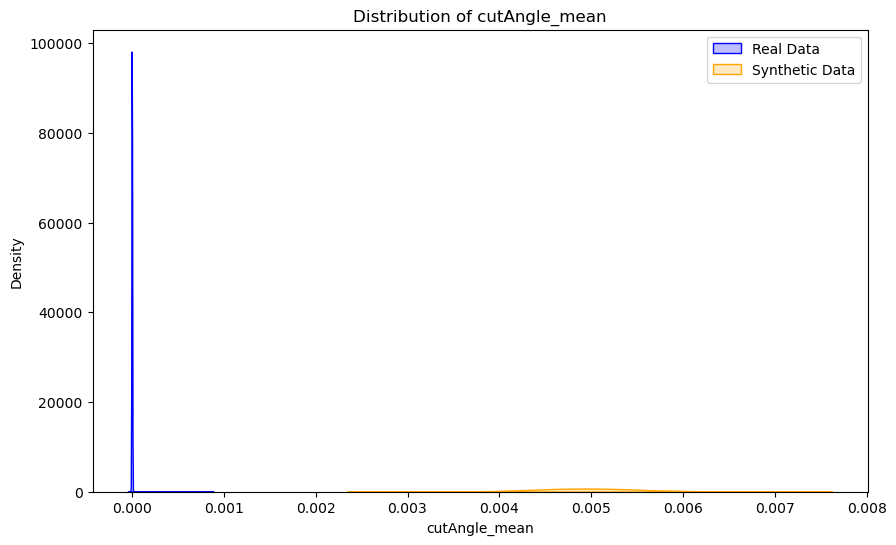

K-S Test for cutAngle_mean:
Statistic = 1.0000, p-value = 0.0000



/tmp/ipykernel_118239/3644699072.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(real_data[feature], color='blue', label='Real Data', shade=True)
/tmp/ipykernel_118239/3644699072.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(synthetic_data[feature], color='orange', label='Synthetic Data', shade=True)


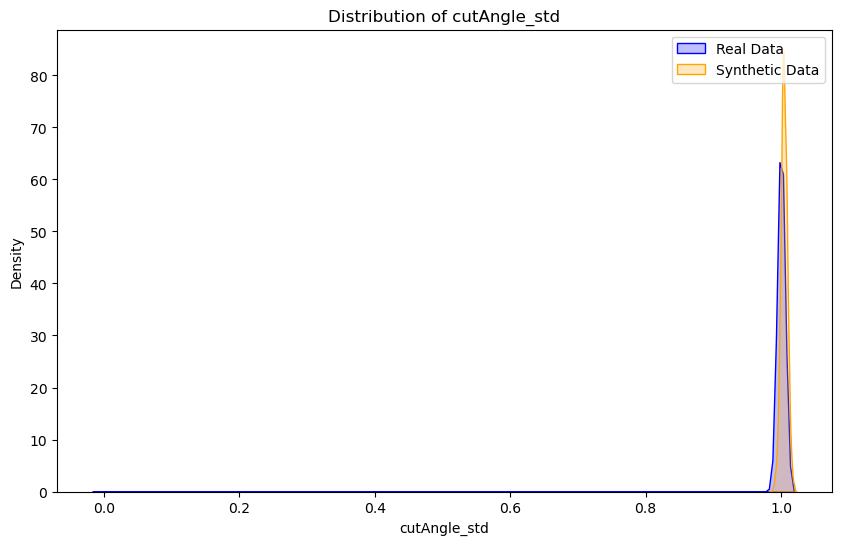

K-S Test for cutAngle_std:
Statistic = 0.8014, p-value = 0.0000



In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Load real and synthetic data
real_data_path = '/srv/fs/my-notebooks/user_skill_feature_mapping.csv'
synthetic_data_path = '/srv/fs/my-notebooks/synthetic_user_data.csv'

real_data = pd.read_csv(real_data_path)
synthetic_data = pd.read_csv(synthetic_data_path)

# Define critical features to compare
features = ['cutDirDeviation_mean', 'cutDirDeviation_std', 
            'cutDistanceToCenter_mean', 'cutDistanceToCenter_std', 
            'saberSpeed_mean', 'saberSpeed_std', 
            'cutAngle_mean', 'cutAngle_std']

# Plot and compare distributions
for feature in features:
    plt.figure(figsize=(10, 6))
    
    sns.kdeplot(real_data[feature], color='blue', label='Real Data', shade=True)
    sns.kdeplot(synthetic_data[feature], color='orange', label='Synthetic Data', shade=True)
    
    plt.title(f'Distribution of {feature}')
    plt.legend()
    plt.show()

    # Kolmogorov-Smirnov Test
    ks_stat, p_value = stats.ks_2samp(real_data[feature], synthetic_data[feature])
    print(f"K-S Test for {feature}:")
    print(f"Statistic = {ks_stat:.4f}, p-value = {p_value:.4f}")
    print("="*50)

    if p_value < 0.05:
        print(f"Warning: {feature} has significantly different distributions in real vs synthetic data (p < 0.05)\n")
    else:
        print(f"Pass: {feature} has similar distributions (p >= 0.05)\n")

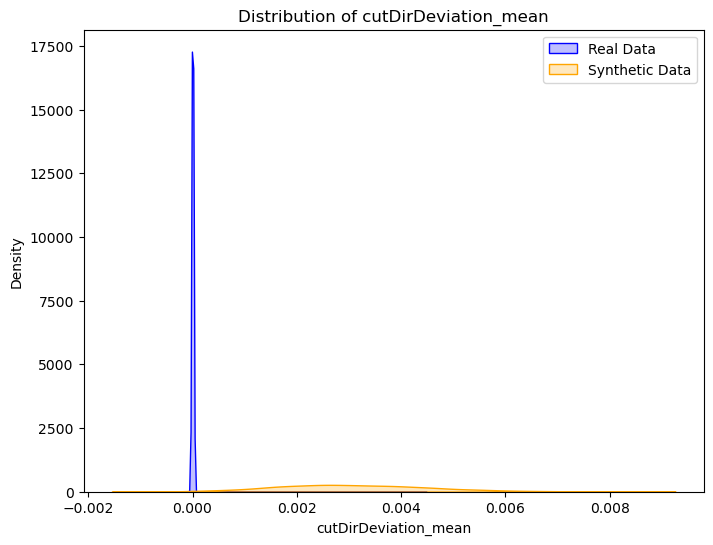

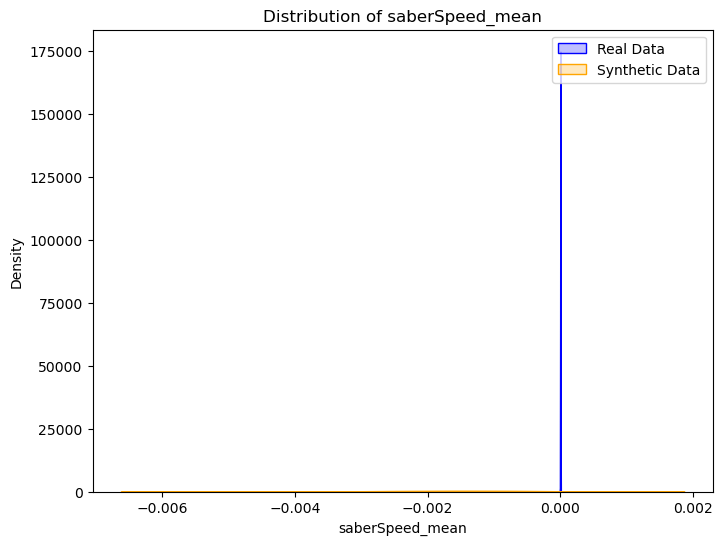

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

real_data_path = '/srv/fs/my-notebooks/user_skill_feature_mapping.csv'
synthetic_data_path = '/srv/fs/my-notebooks/synthetic_user_data.csv'

real_data = pd.read_csv(real_data_path)
synthetic_data = pd.read_csv(synthetic_data_path)

# Define the features to plot
features = ['cutDirDeviation_mean', 'saberSpeed_mean']

# Plot and save KDE plots for the features
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.kdeplot(real_data[feature], color='blue', label='Real Data', fill=True)
    sns.kdeplot(synthetic_data[feature], color='orange', label='Synthetic Data', fill=True)
    plt.title(f'Distribution of {feature}')
    plt.legend()
    plt.savefig(f'kde_{feature}.png')
    plt.show()


In [22]:
import pandas as pd

# Load the synthetic data
synthetic_file_path = 'synthetic_user_data.csv'
synthetic_df = pd.read_csv(synthetic_file_path)

def rank_metric(series, higher_is_better=True):
    if higher_is_better:
        return series.rank(method='average', ascending=False)
    else:
        return series.rank(method='average', ascending=True)

# Rank users based on the features available in the synthetic data
synthetic_df['cutDirDeviation_rank'] = rank_metric(synthetic_df['cutDirDeviation_mean'], higher_is_better=False) 
synthetic_df['cutDistanceToCenter_rank'] = rank_metric(synthetic_df['cutDistanceToCenter_mean'], higher_is_better=False) 
synthetic_df['saberSpeed_rank'] = rank_metric(synthetic_df['saberSpeed_mean'], higher_is_better=True) 
synthetic_df['cutAngle_rank'] = rank_metric(synthetic_df['cutAngle_mean'], higher_is_better=True)

# Combine the ranks into a final score with weighted averages (without 'wasCutTooSoon_mean')
synthetic_df['finalRankScore'] = (
    synthetic_df['cutDirDeviation_rank'] * 0.3 +  # Precision
    synthetic_df['cutDistanceToCenter_rank'] * 0.3 +  # Precision
    synthetic_df['saberSpeed_rank'] * 0.2 +  # Speed
    synthetic_df['cutAngle_rank'] * 0.2  # Consistency
)

# Make sure to scale the final rank score to a 1-10 range
synthetic_df['scaledRankScore'] = 1 + 9 * (synthetic_df['finalRankScore'] - synthetic_df['finalRankScore'].min()) / (synthetic_df['finalRankScore'].max() - synthetic_df['finalRankScore'].min())

# Now round the scaled rank scores to the nearest whole number
synthetic_df['scaledRankScore'] = synthetic_df['scaledRankScore'].round().astype(int)

# Display a preview of the ranked synthetic data
print(synthetic_df[['cutDirDeviation_mean', 'scaledRankScore']].head())

# Save the skill ratings for synthetic data
synthetic_output_file = 'synthetic_user_skill_ratings_ranked_rounded.csv'
synthetic_df[['cutDirDeviation_mean', 'scaledRankScore']].to_csv(synthetic_output_file, index=False)

print(f"Synthetic skill ratings saved with whole numbers to {synthetic_output_file}")


   cutDirDeviation_mean  scaledRankScore
0              0.004383                6
1              0.005827                8
2              0.002816                4
3              0.004282                9
4              0.004226                6
Synthetic skill ratings saved with whole numbers to synthetic_user_skill_ratings_ranked_rounded.csv


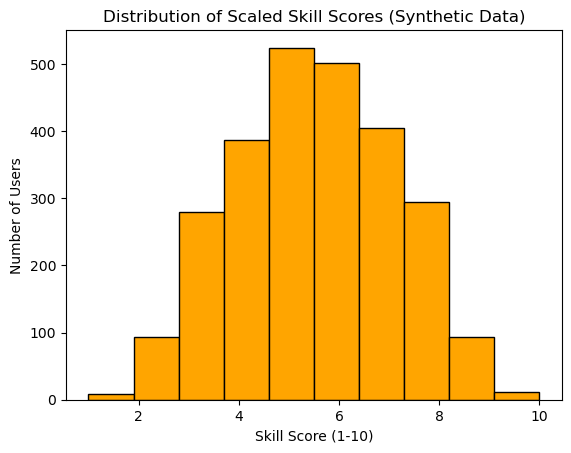

In [27]:
import matplotlib.pyplot as plt

# Plot distribution of scaled skill scores for synthetic data
plt.hist(synthetic_df['scaledRankScore'], bins=10, edgecolor='black', color='orange')
plt.title('Distribution of Scaled Skill Scores (Synthetic Data)')
plt.xlabel('Skill Score (1-10)')
plt.ylabel('Number of Users')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Plot the distribution of the final scaled scores
plt.hist(df['scaledRankScore'], bins=10, edgecolor='black')
plt.title('Distribution of Scaled Skill Scores (Real Data)')
plt.xlabel('Skill Score (1-10)')
plt.ylabel('Number of Users')
plt.show()

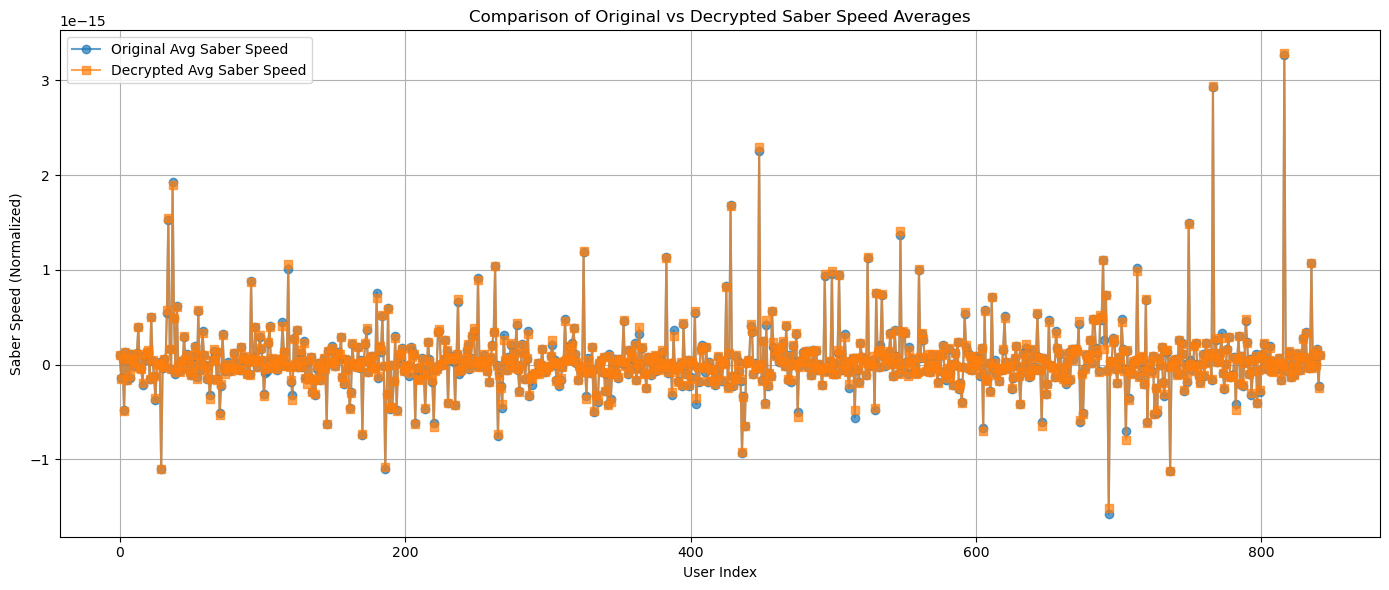

In [32]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load the results CSV
csv_path = "/srv/fs/my-notebooks/user_averages_comparison.csv"

if not os.path.exists(csv_path):
    print(f"Error: File '{csv_path}' not found. Please check the path and try again.")
    exit()

# Load dataset
df = pd.read_csv(csv_path)

# Convert values to numeric to avoid errors
df['original_avg'] = pd.to_numeric(df['original_avg'], errors='coerce')
df['decrypted_avg'] = pd.to_numeric(df['decrypted_avg'], errors='coerce')

# Remove NaN values
df = df.dropna()

# Plot original vs decrypted saber speed averages
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['original_avg'], label='Original Avg Saber Speed', marker='o', linestyle='-', alpha=0.7)
plt.plot(df.index, df['decrypted_avg'], label='Decrypted Avg Saber Speed', marker='s', linestyle='-', alpha=0.7)

plt.xlabel("User Index")
plt.ylabel("Saber Speed (Normalized)")
plt.title("Comparison of Original vs Decrypted Saber Speed Averages")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

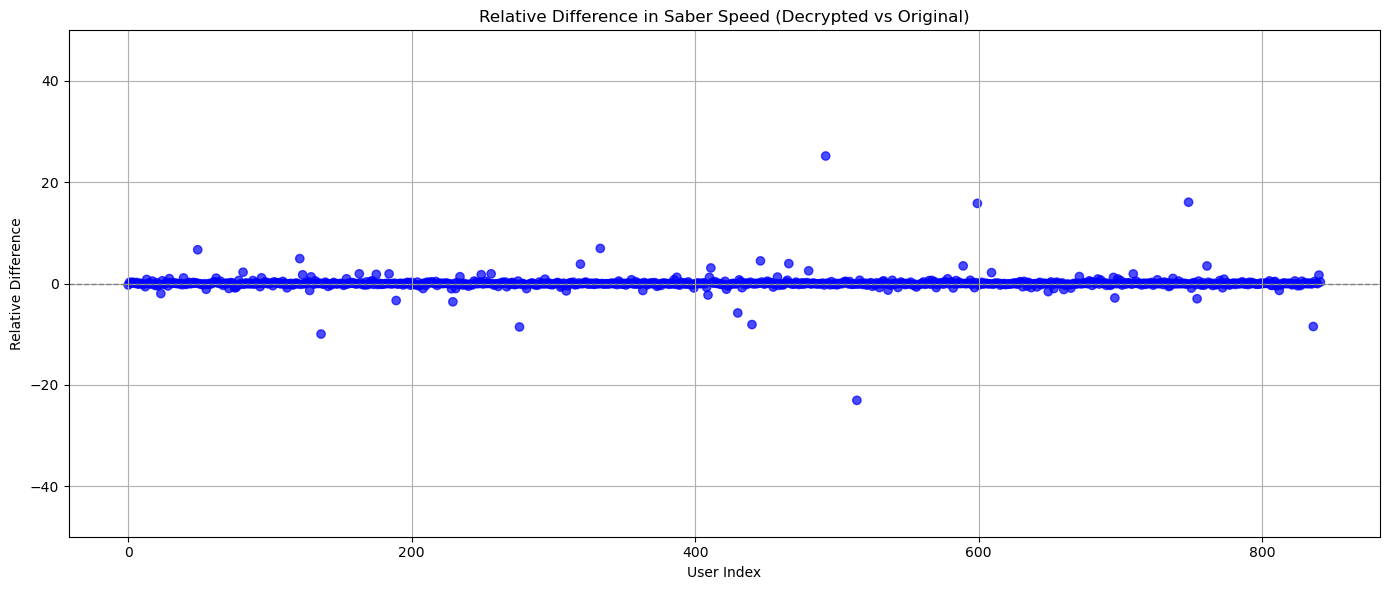

In [34]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load the results CSV
csv_path = "/srv/fs/my-notebooks/user_averages_comparison.csv"

if not os.path.exists(csv_path):
    print(f"Error: File '{csv_path}' not found. Please check the path and try again.")
    exit()

# Load dataset
df = pd.read_csv(csv_path)

# Convert relative difference to numeric to avoid errors
df['relative_difference'] = pd.to_numeric(df['relative_difference'], errors='coerce')

# Remove NaN values
df = df.dropna()

# Define y-axis limits
y_limit = 50

# Plot relative difference with y-axis capped
plt.figure(figsize=(14, 6))
colors = ['red' if abs(x) > y_limit else 'blue' for x in df['relative_difference']]
plt.scatter(df.index, df['relative_difference'], c=colors, alpha=0.7)

plt.ylim(-y_limit, y_limit)
plt.xlabel("User Index")
plt.ylabel("Relative Difference")
plt.title("Relative Difference in Saber Speed (Decrypted vs Original)")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

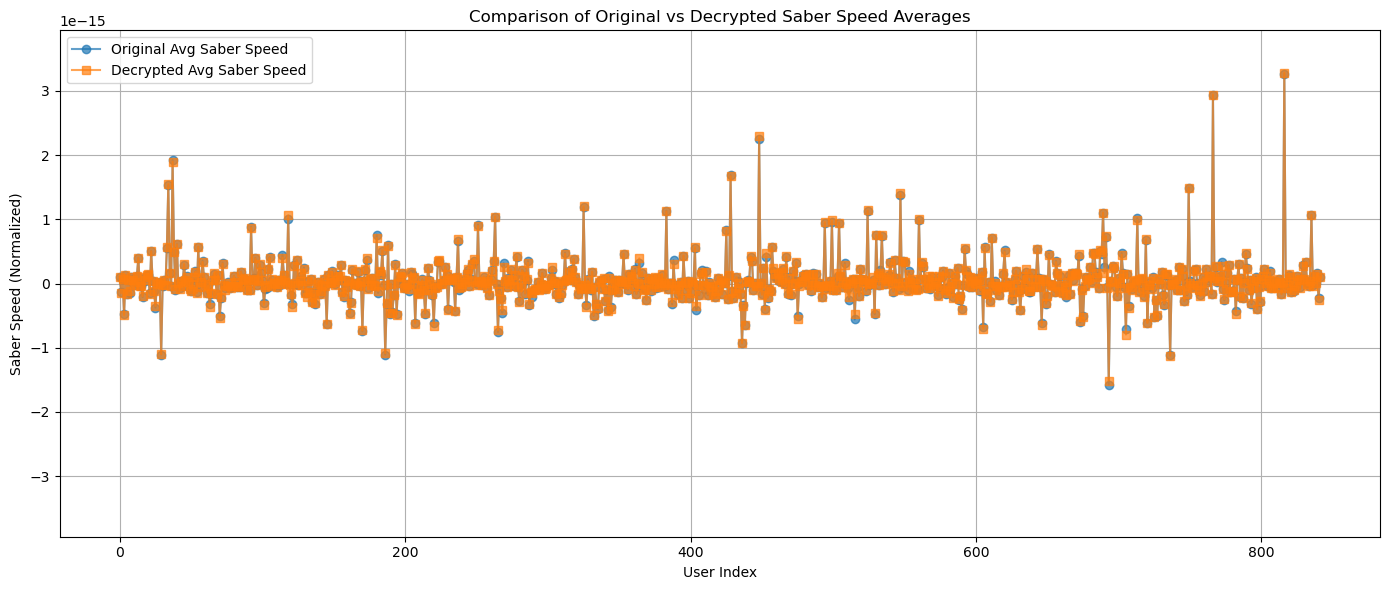

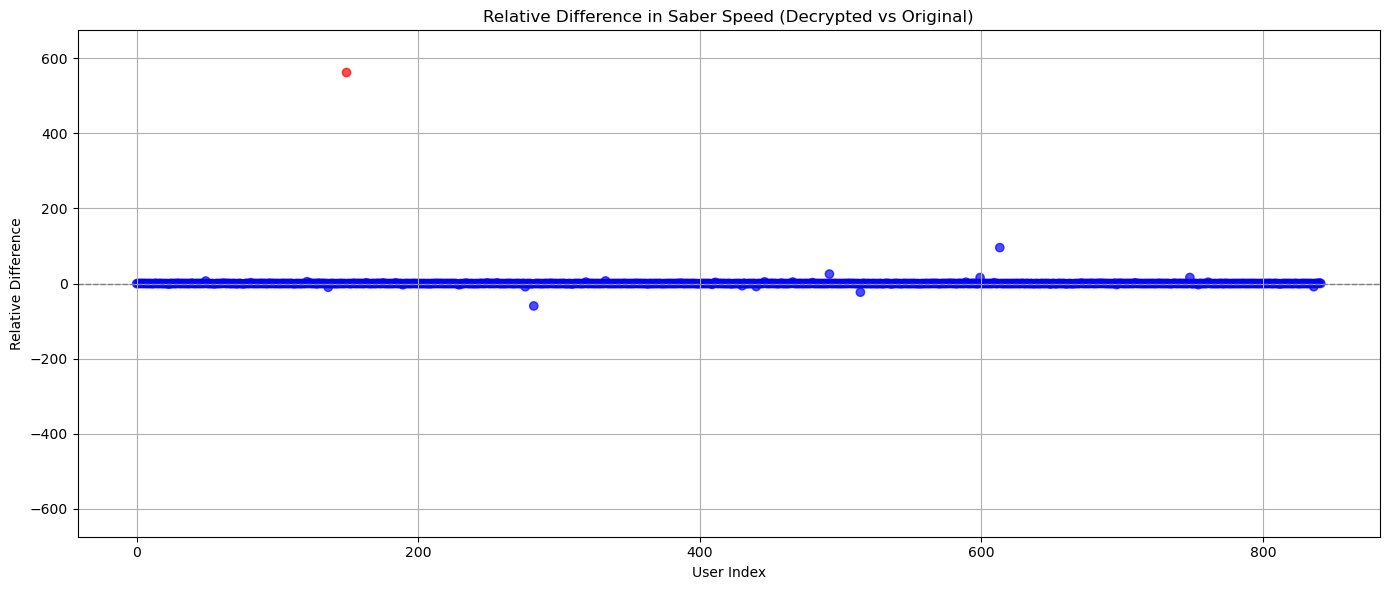

In [38]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load the results CSV
csv_path = "/srv/fs/my-notebooks/user_averages_comparison.csv"

if not os.path.exists(csv_path):
    print(f"Error: File '{csv_path}' not found. Please check the path and try again.")
    exit()

# Load dataset
df = pd.read_csv(csv_path)

# Convert values to numeric to avoid errors
df['original_avg'] = pd.to_numeric(df['original_avg'], errors='coerce')
df['decrypted_avg'] = pd.to_numeric(df['decrypted_avg'], errors='coerce')
df['relative_difference'] = pd.to_numeric(df['relative_difference'], errors='coerce')

# Remove NaN values
df = df.dropna()

# Determine separate y-axis limits
saber_speed_limit = max(abs(df['original_avg'].max()), abs(df['decrypted_avg'].max())) * 1.2
relative_diff_limit = max(abs(df['relative_difference'].max()), abs(df['relative_difference'].min())) * 1.2

# Plot original vs decrypted saber speed averages
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['original_avg'], label='Original Avg Saber Speed', marker='o', linestyle='-', alpha=0.7)
plt.plot(df.index, df['decrypted_avg'], label='Decrypted Avg Saber Speed', marker='s', linestyle='-', alpha=0.7)

plt.ylim(-saber_speed_limit, saber_speed_limit)
plt.xlabel("User Index")
plt.ylabel("Saber Speed (Normalized)")
plt.title("Comparison of Original vs Decrypted Saber Speed Averages")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot relative difference with its own y-axis scaling
plt.figure(figsize=(14, 6))
colors = ['red' if abs(x) > relative_diff_limit / 2 else 'blue' for x in df['relative_difference']]
plt.scatter(df.index, df['relative_difference'], c=colors, alpha=0.7)

plt.ylim(-relative_diff_limit, relative_diff_limit)
plt.xlabel("User Index")
plt.ylabel("Relative Difference")
plt.title("Relative Difference in Saber Speed (Decrypted vs Original)")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.grid(True)
plt.tight_layout()
plt.show()